In [3]:
from torch.utils.data import Dataset, DataLoader
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from transformers.optimization import AdamW
from nltk.translate.bleu_score import corpus_bleu
import torch
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install datasets tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00


In [1]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.4 MB/s eta 0:00:00


In [4]:
# dataset for processing all language data
class LanguageDataset(Dataset):

    def __init__(self, ne_file, en_file, max_length, tokenizer):
        self.ne_file = ne_file
        self.en_file = en_file
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.ne_token = []
        self.en_token = []
        self.en = []
        self.ne = []
        with open(self.ne_file) as file:
            for sentence in file:
                sentence = sentence.strip()
                tokens = tokenizer(sentence, max_length=self.max_length, return_tensors="pt", truncation=True, padding='max_length')
                self.ne.append(sentence)
                self.ne_token.append(tokens)
        with open(self.en_file) as file_en:
            for sentence in file_en:
                sentence = sentence.strip()
                tokens = tokenizer(sentence, max_length=self.max_length, return_tensors="pt", truncation=True, padding='max_length')
                tokens['input_ids'][tokens['attention_mask'] == 0] = -100
                self.en.append(sentence)
                self.en_token.append(tokens)

    def __len__(self):
        return len(self.ne_token)

    # input_ids attention_mask encoder_mask decoder_mask
    def __getitem__(self, idx):
        return {
            'ne_tokens': self.ne_token[idx]['input_ids'][0],
            'ne_mask': self.ne_token[idx]['attention_mask'][0],
            'en_tokens': self.en_token[idx]['input_ids'][0],
            'en_mask': self.en_token[idx]['attention_mask'][0],
            'en': self.en[idx],
            'ne': self.ne[idx]
        }

In [5]:
# config
DIR_PATH = "workspace/"
MAX_LENGTH = 1024
BATCH_SIZE = 8
fine_tune = True
device = 'cuda'

# New Section

In [6]:
# init model and tokenizer
model_name = "facebook/mbart-large-50-many-to-many-mmt"
model = MBartForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
tokenizer.src_lang = "ne_NP"
tokenizer.tgt_lang = "en_XX"

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

In [ ]:
# train data
train_dataset = LanguageDataset(f'{DIR_PATH}/train.ne_NP.txt', f'{DIR_PATH}/train.en_XX.txt', MAX_LENGTH, tokenizer)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# test data
test_dataset = LanguageDataset(f'{DIR_PATH}/test.ne_NP.txt', f'{DIR_PATH}/test.en_XX.txt', MAX_LENGTH, tokenizer)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
'''
Perform fine-tuning of mBART in case the flag is set appropriately
You can check out references like these to understand the code better:
    - https://colab.research.google.com/drive/1d2mSWLiv93X2hgt9WV8IJFms9dQ6arLn?usp=sharing
    - https://github.com/huggingface/transformers/issues/23185#issuecomment-1537690520
'''

if fine_tune:

    optimizer = AdamW(model.parameters(), lr=1e-5)
    model.train()
    num_epochs = 10
    training_losses = []
    testing_losses = []
    bleu_scores = []
    # Fine-tune for the specified number of epochs
    for i in range(num_epochs):
        print(f'epoch {i+1} of {num_epochs}')

        #train
        total_batches_training = len(train_loader)
        epoch_training_loss = 0
        for batch in tqdm(train_loader, total=total_batches_training, desc="Training", unit="batch"):
            model_inputs = {
                'input_ids': batch['ne_tokens'].to(device),
                'attention_mask': batch['ne_mask'].to(device)
            }
            labels = batch['en_tokens'].to(device)
            optimizer.zero_grad()
            output = model(**model_inputs, labels=labels)  # Forward pass
            loss = output.loss
            epoch_training_loss = loss.cpu().detach().numpy() + epoch_training_loss
            loss.backward()  # Backward pass
            optimizer.step()
        epoch_training_loss = epoch_training_loss/total_batches_training
        training_losses.append(epoch_training_loss)

        #get test loss
        epoch_testing_loss = 0
        total_batches_testing = len(test_loader)
        for batch in tqdm(test_loader, total=total_batches_testing, desc="Testing", unit="batch"):
            model_inputs = {
                'input_ids': batch['ne_tokens'].to(device),
                'attention_mask': batch['ne_mask'].to(device)
            }
            labels = batch['en_tokens'].to(device)
            outputs = model(**model_inputs, labels=labels)
            loss = outputs.loss
            epoch_testing_loss = loss.cpu().detach().numpy() + epoch_testing_loss
        epoch_testing_loss = epoch_testing_loss/total_batches_testing
        testing_losses.append(epoch_testing_loss)

        #get bleu score
        generated_translations = []
        reference = []
        for batch in tqdm(test_dataset, total=len(test_dataset), desc="Bleu Score", unit="batch"):
            # get generated translation
            input_ids = tokenizer(batch['ne'], return_tensors="pt").input_ids.to(device)
            forced_bos_token_id = tokenizer.lang_code_to_id["en_XX"]
            outputs = model.generate(input_ids=input_ids, forced_bos_token_id=forced_bos_token_id, max_length=MAX_LENGTH)
            english_translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
            generated_translations.append(english_translation)

            # get label
            reference.append(batch['en'])

        hypotheses = [gen.split() for gen in generated_translations]
        references = [[ref.split()] for ref in reference]
        bleu_score = corpus_bleu(references, hypotheses)
        bleu_scores.append(bleu_score)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch 1 of 5


Training:  18%|█▊        | 3681/20454 [18:03<1:22:36,  3.38batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training:  67%|██████▋   | 13731/20454 [1:07:34<33:08,  3.38batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Bleu Score: 100%|██████████| 1012/1012 [06:44<00:00,  2.50batch/s]


epoch 5 of 5


Training:  27%|██▋       | 5602/20454 [27:31<1:12:59,  3.39batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training:  87%|████████▋ | 17890/20454 [1:28:02<12:36,  3.39batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Bleu Score: 100%|██████████| 1012/1012 [06:44<00:00,  2.50batch/s]


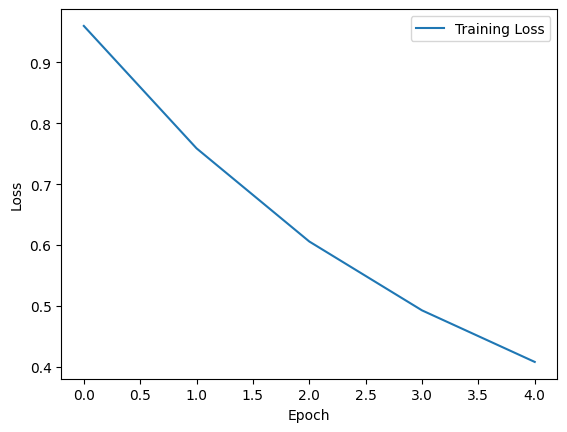

In [ ]:
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

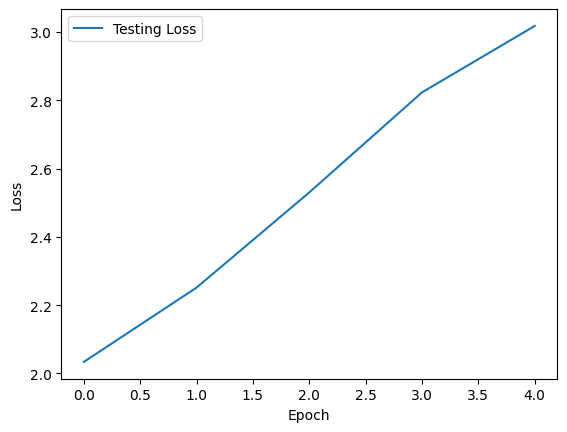

In [ ]:
plt.plot(testing_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

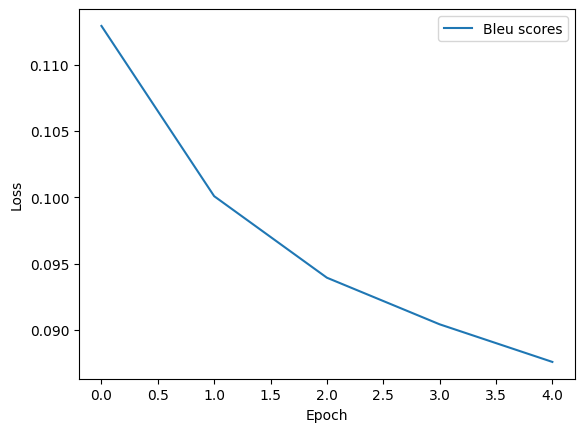

In [ ]:
plt.plot(bleu_scores, label='Bleu scores')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# compute bleu score without fine tuning
generated_translations = []
reference = []

for batch in tqdm(test_dataset, total=len(test_dataset), desc="Bleu Score", unit="batch"):

    # get generated translation
    input_ids = tokenizer(batch['ne'], return_tensors="pt").input_ids.to(device)
    forced_bos_token_id = tokenizer.lang_code_to_id["en_XX"]
    outputs = model.generate(input_ids=input_ids, forced_bos_token_id=forced_bos_token_id, max_length=MAX_LENGTH)
    english_translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_translations.append(english_translation)

    # get label
    reference.append(batch['en'])

hypotheses = [gen.split() for gen in generated_translations]
references = [[ref.split()] for ref in reference]
bleu_score = corpus_bleu(references, hypotheses)

print("bleu score: ", bleu_score)

Bleu Score: 100%|██████████| 1012/1012 [06:48<00:00,  2.48batch/s]

bleu score:  0.1068675922688707


In [12]:
# Initialize variables for calculating cross-entropy
total_nll = 0  # Total Negative Log-Likelihood
total_tokens = 0  # Total number of tokens

for batch in tqdm(test_dataset, total=len(test_dataset), desc="Calculating Cross-Entropy", unit="batch"):
    # Tokenize input and reference
    input_ids = tokenizer(batch['ne'], return_tensors="pt").input_ids.to(device)
    reference_ids = tokenizer(batch['en'], return_tensors="pt").input_ids.to(device)

    # Forward pass to get token logits
    with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=reference_ids)
        logits = outputs.logits

    # Shift the logits and labels for calculating NLL
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = reference_ids[..., 1:].contiguous()

    # Flatten the logits and labels for simplicity
    loss_fct = torch.nn.CrossEntropyLoss(reduction='sum')
    nll = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

    total_nll += nll.item()
    total_tokens += shift_labels.ne(tokenizer.pad_token_id).sum().item()

# Calculate average cross-entropy
cross_entropy = total_nll / total_tokens
print("Average Cross-Entropy:", cross_entropy)

Calculating Cross-Entropy: 100%|██████████| 1012/1012 [00:39<00:00, 25.74batch/s]

Average Cross-Entropy: 9.12466689224732
